In [9]:
import numpy as np
import tensorflow as tf
import keras
import keras.layers as layers

import pandas as pd
import matplotlib.pyplot as plt
#import datetime as dt
import numpy as np
#import seaborn as sns
import scipy.interpolate
from scipy.ndimage import gaussian_filter1d

def logNorm(inputs, scale, bias, mu, sigma):
    X = np.maximum(inputs - bias, 0) + 1e-8
    return scale * (np.exp(-(np.log(X) - mu)**2 / (2 * sigma**2)) / (X * sigma * np.sqrt(2 * np.pi)))

def prefixSum(sigmaInc, id):
    return sum(np.maximum(sigmaInc[i], 0) + 0.05 for i in range(0,id+1))
    
cols = ['Unnamed', 'Days', 'Catches']

class ProbLayer(tf.keras.layers.Layer):
  def __init__(self, scale, bias, mu, sigmaInc, **kwargs):
    super(ProbLayer, self).__init__( **kwargs)
    self.iscale = tf.math.log(scale)
    self.ibias = bias
    self.imu = mu
    self.isigmaInc = sigmaInc

  def build(self, input_shape):
    self.total = len(self.ibias)
    self.scale = self.add_weight("scale", shape=(self.total,), 
               initializer=keras.initializers.Constant(self.iscale))
    self.bias = self.add_weight("bias", shape=(self.total,), 
               initializer=keras.initializers.Constant(self.ibias))
    self.mu = self.add_weight("mu", initializer=keras.initializers.Constant(self.imu))
    #self.mu = self.add_weight("mu", shape=(self.total,), initializer=keras.initializers.Constant(self.isigma))
    self.sigmaInc = self.add_weight("sigmaInc", shape=(self.total,), initializer=keras.initializers.Constant(self.isigmaInc))

  def logNorm(self, inputs, scale, id):
    # sigmas must be positive and always increase
    sigma = sum(tf.nn.relu(self.sigmaInc[i]) + 0.01 for i in range(0,id+1))
    X = tf.nn.relu(inputs - self.bias[id]) + 1e-9
    return scale[id] * (tf.math.exp(-(tf.math.log(X) - self.mu)**2 / (2 * sigma**2)) / (X * sigma * tf.math.sqrt(2 * np.pi)))

  def call(self, inputs):
    scale = tf.nn.softmax(self.scale) # make sure scales some up to 1
    A = sum(self.logNorm(inputs,scale,id) for id in range(0,self.total))
    return A


19009
Scale =  [0.5, 0.4, 0.1]


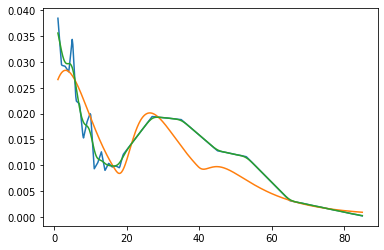

In [11]:
csv = pd.read_csv('C:/work/ImageProcDocs/Python-playground/FishPopulation/nosed.csv')
y0 = csv[cols[2]]
y = y0 / sum(y0)
print(sum(y0))

x0 = list(range(1,len(y)+1,1))
fI = scipy.interpolate.interp1d(x0, y, kind='linear')
xI = np.linspace(x0[0],x0[-1], 512)
yI = fI(xI)
zI = gaussian_filter1d(yI, 6, mode='nearest')

scale = [0.5,0.4,0.1]
print("Scale = ", scale)
aa=11
bias = [0 - aa,27-aa,50-aa]
mu = 2.85
sigma = [0.4,0.15,0.05]

#bias=[-24.354303, 5.7943015, 26.09499] 
#mu = 3.3170514
#sigma=[0.20614398,  0.09253789, -0.00944026]
#print(list(prefixSum(sigma,i) for i in range(0,3)))

zA = sum(logNorm(xI,scale[i],bias[i],mu,prefixSum(sigma,i)) for i in range(0,3))
plt.plot(xI, yI)
plt.plot(xI,zA)
plt.plot(xI, zI)
plt.show()


In [12]:
M = keras.Sequential([
    #keras.Input()
   # nosed simulation (group I)
   ProbLayer(input_shape=(1,),
             scale=[0.3,0.3,0.3],
             bias=[-20,10,40],
             mu=2.85,
             sigmaInc=[0.4,0.2,0.1])
])

M.summary()
M.compile(tf.optimizers.Adam(learning_rate=0.0025), loss='mse')
M.fit(xI, zI, batch_size=64, epochs=3000)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prob_layer_3 (ProbLayer)    (None, 1)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3000
8/8 [==============================] - 1s 11ms/step - loss: 5.8419e-05
Epoch 2/3000
8/8 [==============================] - 0s 10ms/step - loss: 5.4390e-05
Epoch 3/3000
8/8 [==============================] - 0s 10ms/step - loss: 5.0348e-05
Epoch 4/3000
8/8 [==============================] - 0s 12ms/step - loss: 4.6023e-05
Epoch 5/3000
8/8 [==============================] - 0s 10ms/step - loss: 4.1673e-05
Epoch 6/3000
8/8 [==============================] - 0s 10ms/step - loss: 3.7656e-05
Epoch 7/3000
8/8 [==============================] - 0s 10ms/step - loss: 3.3478e-0

[array([-0.67740643, -0.44921347, -1.4518938 ], dtype=float32), array([-21.941952,   5.440454,  23.866613], dtype=float32), 3.2714922, array([ 0.18602762,  0.21164154, -0.00136779], dtype=float32)]
scale =  [0.36801672 0.46234962 0.16963366]
bias =  [-21.941952   5.440454  23.866613]
mu =  3.2714922
sigma =  [0.19602761626243592, 0.41766915142536165, 0.42766915142536166]


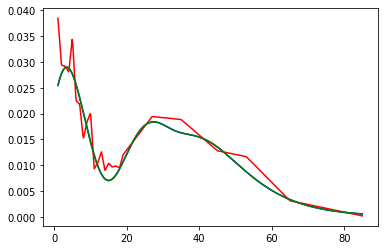

In [13]:
print(M.layers[0].get_weights())

L = M.layers[0]
scale,bias,mu,sInc = L.get_weights()
scale = tf.nn.softmax(scale)
print("scale = ", scale.numpy())
print("bias = ", bias)
print("mu = ", mu) 
S = [sum(np.maximum(sInc[i],0) + 0.01 for i in range(0,id+1)) for id in range(0, len(sInc))]
print("sigma = ", S)
zz = L(xI)
zA = sum(logNorm(xI,scale[i],bias[i],mu,S[i]) for i in range(0,3))

plt.plot(xI,zA, 'b')
plt.plot(xI, yI, 'r')
plt.plot(xI, zz, 'g')
plt.show()

[0.4, 0.4, 0.15]


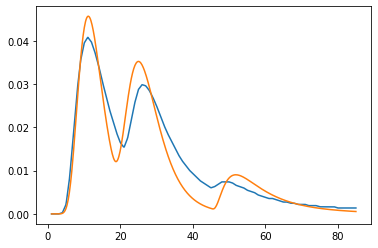

In [14]:
csv = pd.read_csv('C:/work/ImageProcDocs/Python-playground/FishPopulation/white.csv')
y0 = csv[cols[2]]
y = y0 / sum(y0)
x0 = list(range(1,len(y)+1,1))
fI = scipy.interpolate.interp1d(x0, y, kind='linear')
xI = np.linspace(x0[0],x0[-1], 512)
yI = fI(xI)
zI = gaussian_filter1d(yI, 3, mode='nearest')

scale = [0.4,0.4,0.15]
#scale = np.array(scale) / sum(y0)
print(scale)
bias = [0,15,45]
mu = 2.5
sigma = [0.3,0.42,0.74]

zA = sum(logNorm(xI,scale[i],bias[i],mu,sigma[i]) for i in range(0,3))
plt.plot(xI, yI)
plt.plot(xI,zA)
#plt.plot(xI, zI)
plt.show()


In [15]:
M = keras.Sequential([
   # white simulation (group II)
   ProbLayer(input_shape=(1,),
              scale=[0.4,0.4,0.15],
              bias=[0,15,45],
              mu=2.5,
              sigmaInc=[0.3,0.11,0.31])
])

M.summary()
M.compile(tf.optimizers.Adam(learning_rate=0.0025), loss='mse')
M.fit(xI, zI, batch_size=64, epochs=3000)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prob_layer_4 (ProbLayer)    (None, 1)                 10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3000
8/8 [==============================] - 1s 13ms/step - loss: 1.3023e-05
Epoch 2/3000
8/8 [==============================] - 0s 12ms/step - loss: 1.0251e-05
Epoch 3/3000
8/8 [==============================] - 0s 12ms/step - loss: 8.9184e-06
Epoch 4/3000
8/8 [==============================] - 0s 11ms/step - loss: 8.0221e-06
Epoch 5/3000
8/8 [==============================] - 0s 11ms/step - loss: 7.4334e-06
Epoch 6/3000
8/8 [==============================] - 0s 11ms/step - loss: 6.8349e-06
Epoch 7/3000
8/8 [==============================] - 0s 10ms/step - loss: 6.3264e-0

[array([-0.6687262 , -0.91056013, -2.5497875 ], dtype=float32), array([ 1.7345766, 19.996706 , 45.326385 ], dtype=float32), 2.488845, array([0.4723609 , 0.23602544, 0.18346466], dtype=float32)]
scale =  [0.51609844 0.40523356 0.07866798]
bias =  [ 1.7345766 19.996706  45.326385 ]
mu =  2.488845
sigma =  [0.48236090898513795, 0.7283863466978073, 0.921851007938385]


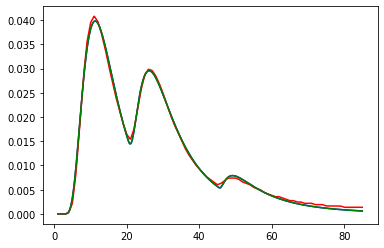

In [16]:
print(M.layers[0].get_weights())

L = M.layers[0]
scale,bias,mu,sInc = L.get_weights()
scale = tf.nn.softmax(scale)
print("scale = ", scale.numpy())
print("bias = ", bias)
print("mu = ", mu) 
S = [sum(np.maximum(sInc[i],0) + 0.01 for i in range(0,id+1)) for id in range(0, len(sInc))]
print("sigma = ", S)
zz = L(xI)
zA = sum(logNorm(xI,scale[i],bias[i],mu,S[i]) for i in range(0,3))

plt.plot(xI,zA, 'b')
plt.plot(xI, yI, 'r')
plt.plot(xI, zz, 'g')
plt.show()